# Convolutional Neural Networks: Build an image classifier using pytorch

In [50]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from PIL import Image
from scipy import ndimage
from fastai.vision.all import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
np.random.seed(1)

In [51]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        if self.transform:            
            tfmd_img = self.transform(self.img_arr[index])
            # ToTensor transformation causes the RGB channel dimension to shift from index 2 to 0
            # we interchange the dimensions at index 0 and 2 to move channel dim back to index 2
        #return (tfmd_img.transpose(0,2), self.label_arr[index])
        return (tfmd_img, self.label_arr[index])

Run the next cell to load the "SIGNS" dataset you are going to use.

In [52]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape)
print(test_x.shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)


In [53]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=5, X=train_x, y=train_y)
fold1 = train_y[k_folds == 1] 

There are 1080 images of dimension 64 by 64 by 3 in train dataset

In [54]:
def get_imgs_mean_stddev(imgs, axis=None):    
    """Get the mean and standard deviation for images in a dataset / mini-batch
    Args:
        imgs ([2d or 3d numpy array]): images in collection (with no to_tensor transformation applied)
        axis ([tuple of ints], optional): Axis along which mean and std dev is to be calculated.
        Defaults to None.
    Returns:
        [tuple]: tuple of tensors with mean and std.dev. of the imgs
    """
    to_tensor = transforms.ToTensor()
    img_tensor_arr = [to_tensor(img) for img in train_x]
    # stack will arrange the tensors one over the other with dim=0 being the new dimension that  
    # stores the number of tensors stacked. This new dimension can be placed at any index
    img_tensor_arr = torch.stack(img_tensor_arr)
    if axis is not None:
        return torch.mean(img_tensor_arr, axis=axis), torch.std(img_tensor_arr, axis=axis)
    else:            
        return torch.mean(img_tensor_arr, axis=(0, 2, 3)), torch.std(img_tensor_arr, axis=(0,2,3))
    
train_img_mean, train_img_std = get_imgs_mean_stddev(train_x)        
print(train_img_mean, train_img_std)

tensor([0.7630, 0.7105, 0.6634]) tensor([0.1538, 0.1998, 0.2221])


In [55]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(train_img_mean, train_img_std)])

# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train_signs = NpArrayImageDataset(train_X, train_y, transform=img_transforms)
    ds_val_signs = NpArrayImageDataset(val_X, val_y, transform=img_transforms)
    dl_train = DataLoader(ds_train_signs, batch_size=64, shuffle=True)
    dl_val = DataLoader(ds_val_signs, batch_size=64, shuffle=True)
    return dl_train, dl_val

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="../images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

Image label = 5


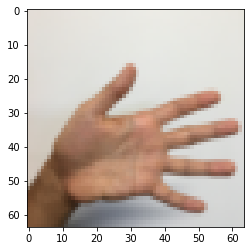

In [56]:
# display an untransformed image
plt.imshow(train_x[0])
print(f"Image label = {train_y[0]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

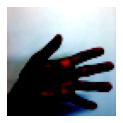

In [57]:
# display the same image but this time transformed
tfmd_img = img_transforms(train_x[0])
show_image(tfmd_img)

## Build a convolution net. We are inspired by the classic LeNet architecture

In [99]:
class LeNet(nn.Module):
    def __init__(self, input_ch, out_class_count):
        super().__init__()
        # no of channels in input image. Input image is of shape (64, 64, 3)
        self.input_ch = input_ch
        # no of unique output class labels
        self.out_class_count = out_class_count
        # The first convolution layer
        self.conv1 = nn.Sequential(
            # use 10 in place of 6 as the no of out channels in first convolution layer to increase
            # network performance
            nn.Conv2d(in_channels=input_ch, out_channels=10, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from first conv layer has shape (15, 15, 20)
        # second convolution layer
        self.conv2 = nn.Sequential(
            # use 25 in place of 16 (as per original network architecture) as the 
            # no of out channels in 2nd convolution layer to increase network performance
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from 2nd conv layer has dim (3, 3, 50). 
        self.conv3 = nn.Sequential(
            # use 50 in place of 16 (as per original network architecture) as the 
            # no of out channels in 2nd convolution layer to increase network performance
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        # output from 3rd conv layer has shape (4, 4, 50)
        self.fc1 = nn.Linear(in_features=800, out_features=200)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=200, out_features=out_class_count)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size = x.shape[0]        
        x = self.conv1(x)        
        x = self.conv2(x)
        x = self.conv3(x)        
        # flatten the output from the last conv layer into 1d tensor        
        x = x.view(batch_size, -1)        
        x = self.fc1(x)        
        x = self.relu1(x)
        x = self.fc2(x)
        output = self.logsoftmax(x)
        return output

In [92]:
model1 = nn.Sequential(
            # use 10 in place of 6 as the no of out channels in first convolution layer to increase
            # network performance
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

model2 = nn.Sequential(
            # use 25 in place of 16 (as per original network architecture) as the 
            # no of out channels in 2nd convolution layer to increase network performance
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )        

model3 = nn.Sequential(
             # use 50 in place of 16 (as per original network architecture) as the 
             # no of out channels in 2nd convolution layer to increase network performance
             nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=1),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
         )        

input_img = torch.stack([tfmd_img], dim=0)  
out1 = model1(input_img)
print(out1.shape)
out2 = model2(out1)
print(out2.shape)
out3 = model3(out2)
print(out3.shape)
x = out3.view(1,-1)
print(x.shape)
fc1 = nn.Linear(in_features=800, out_features=200)
x = fc1(x)
print(x.shape)

torch.Size([1, 10, 30, 30])
torch.Size([1, 25, 13, 13])
torch.Size([1, 50, 4, 4])
torch.Size([1, 800])
torch.Size([1, 200])


In [100]:
# CONSTANTS 
NUM_FOLDS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

model = LeNet(3, 6).to(DEVICE)

In [65]:
def get_fold_dls(fold, kfolds, X, y):
    train_X = X[kfolds != fold+1]
    train_y = y[kfolds != fold+1]    
    valid_X = X[kfolds == fold+1]
    valid_y = y[kfolds == fold+1]
    print(len(train_X), len(train_y), len(valid_X), len(valid_y))
    ds_train = NpArrayImageDataset(train_X, train_y, img_transforms)
    ds_valid = NpArrayImageDataset(valid_X, valid_y, img_transforms)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)
    return dl_train, dl_valid

864 864 216 216


epoch,train_loss,valid_loss,accuracy,time
0,0.010061,0.617140,0.847222,00:02
1,0.011052,0.697084,0.870370,00:02
2,0.015836,0.820099,0.856481,00:03
3,0.028828,0.811174,0.837963,00:02
4,0.048083,0.629575,0.842593,00:02
5,0.056028,0.978088,0.810185,00:02
6,0.068486,1.082722,0.759259,00:02
7,0.196204,0.952174,0.708333,00:02
8,0.219254,1.041691,0.736111,00:02
9,0.215638,0.568181,0.856481,00:02


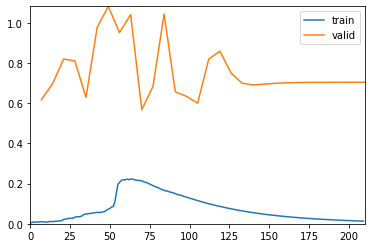

864 864 216 216


epoch,train_loss,valid_loss,accuracy,time
0,0.169361,0.000495,1.000000,00:02
1,0.122914,0.006478,1.000000,00:02
2,0.092014,0.024839,0.986111,00:02
3,0.071119,0.021950,0.990741,00:02
4,0.055757,0.021667,0.990741,00:02
5,0.047202,0.125903,0.953704,00:02
6,0.070976,1.598175,0.851852,00:02
7,0.152090,0.209089,0.949074,00:02
8,0.152370,0.419980,0.907407,00:02
9,0.155240,0.192092,0.953704,00:02


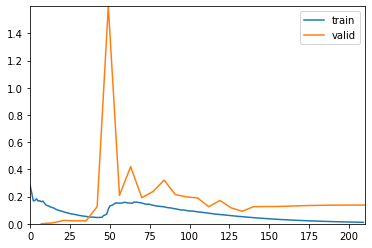

864 864 216 216


epoch,train_loss,valid_loss,accuracy,time
0,0.031012,0.000059,1.000000,00:02
1,0.017526,0.000282,1.000000,00:02
2,0.011543,0.000817,1.000000,00:02
3,0.008075,0.014060,0.995370,00:02
4,0.005987,0.031165,0.995370,00:02
5,0.004609,0.038391,0.995370,00:02
6,0.003642,0.040023,0.995370,00:02
7,0.002933,0.040771,0.995370,00:02
8,0.002396,0.041721,0.995370,00:02
9,0.001978,0.042568,0.995370,00:02


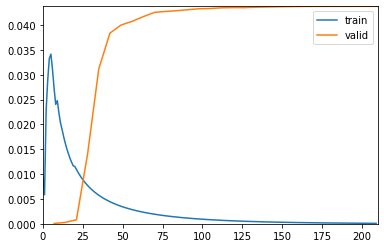

864 864 216 216


epoch,train_loss,valid_loss,accuracy,time
0,0.010345,0.000000,1.000000,00:02
1,0.004811,0.000000,1.000000,00:02
2,0.003012,0.000031,1.000000,00:02
3,0.002097,0.005612,0.995370,00:02
4,0.001557,0.049400,0.995370,00:02
5,0.016658,0.064895,0.981481,00:02
6,0.173022,0.952107,0.902778,00:02
7,0.238769,1.416641,0.893519,00:02
8,0.291281,0.128913,0.962963,00:02
9,0.260375,0.183147,0.962963,00:02


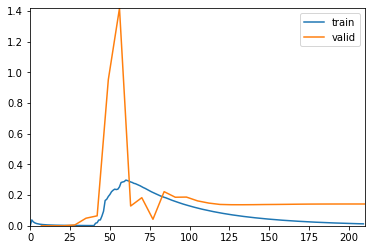

864 864 216 216


epoch,train_loss,valid_loss,accuracy,time
0,0.034804,0.000049,1.000000,00:02
1,0.023828,0.000199,1.000000,00:02
2,0.016267,0.001685,1.000000,00:02
3,0.012370,0.001441,1.000000,00:02
4,0.016263,0.001933,1.000000,00:02
5,0.019780,0.066167,0.981481,00:02
6,0.045045,0.361358,0.967593,00:02
7,0.080810,0.251178,0.949074,00:02
8,0.114093,0.173142,0.962963,00:02
9,0.127122,0.580903,0.930556,00:02


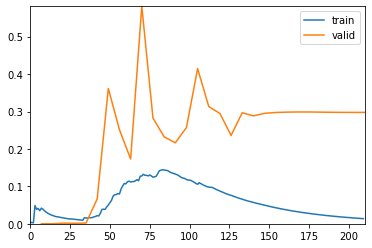

In [102]:
# instantiate the model
# define the loss function, optimizer, hyperparameters and metrics to measure model performance
from fastai.data.core import DataLoaders
from fastai.optimizer import OptimWrapper
from torch import optim 
from functools import partial
from fastai.callback.schedule import Learner
from fastai.metrics import accuracy
import torch.nn.functional as F

for fold in range(NUM_FOLDS):
    dl_train, dl_valid = get_fold_dls(fold, k_folds, train_x, train_y)
    dls = DataLoaders(dl_train, dl_valid)
    opt_func = partial(OptimWrapper, opt=optim.Adam)
    learn = Learner(dls, model, loss_func=F.nll_loss, opt_func=opt_func, metrics=accuracy)
    #learn.summary()
    learn.fit_one_cycle(n_epoch=30, lr_max=1e-2, cbs=[ShowGraphCallback()])
    learn.save(f"model_fold{fold}", with_opt=False)    

In [ ]:
# augment the training dataset with image transforms and see what difference does data augmentation
# makes to model performance

In [19]:
# perform inference on test set using the best model